In [1]:
import os
from os.path import isfile, join, abspath, basename
from optparse import OptionParser
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy
import json

import sys
parentdir = os.path.abspath('/home/xcheng/mvesc/ETL')
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *

import inspect
import datetime
from itertools import chain, groupby
import matplotlib.pyplot as plt
import matplotlib
from pandas.tools.plotting import table

matplotlib.style.use('ggplot')
get_ipython().magic('matplotlib')
from mvesc_utility_functions import *
%load_ext autotime
%matplotlib inline

Using matplotlib backend: agg


# Planning: what features to include

1. number of absent days & unexecused absence days;
2. number of tardy & unexecused tardy;
2. 

In [2]:
import os, sys
pathname = os.path.dirname(sys.argv[0])
full_pathname = os.path.abspath(pathname)
split_pathname = full_pathname.split(sep="mvesc")
base_pathname = os.path.join(split_pathname[0], "mvesc")
parentdir = os.path.join(base_pathname, "ETL")
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd


# functions
def create_feature_table(cursor, table, schema = 'model', replace = False):
    """
    The current feature table is dropped and re-created with a single column
    containing unique student lookups numbers, set as an index
    :param pg_cursor cursor:
    :param str table: feature table name 
    :param str schema: schema name for feature table
    :param bool replace: if true the table will be replaced, 
        if false an existing table will not be altered
    """
    cursor.execute("""
    select count(*) from information_schema.tables
    where table_schema = '{schema}' and table_name = '{table}'
    """.format_map({'schema':schema,'table':table}))
    table_exists = cursor.fetchall()[0][0]
    if (not table_exists) or replace:
        sql_drop = "drop table if exists {schema}.{table};"\
            .format(schema=schema, table=table)
        sql_create = """                                                     
        create table {schema}.{table} as                                     
        ( select distinct student_lookup                                     
        from clean.wrk_tracking_students                                   
        where outcome_category is not null                                 
        );""".format(schema=schema, table=table)
        cursor.execute(sql_drop);
        cursor.execute(sql_create);
        sql_create_index = """                                               
        create index {schema}_{table}_lookup_index on {schema}.{table}(student_lookup)
        """.format(schema=schema, table=table)
        cursor.execute(sql_create_index)
        print(""" - Table {schema}.{table} created!"""\
        .format(schema=schema, table=table))

def update_column_with_join(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', dtype='varchar(64)', grade=9):
    """ 
    Update column using join to match another table                 
    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    dtype = get_column_type(cursor, source_table, source_column)
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default null;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select {source_column} from {source_schema_and_table} t2
    where t2.student_lookup=t1.student_lookup and t2.{source_column} is not null
    and t2.grade={grade}
    order by {source_column} desc limit 1);
    """.format(schema=schema, table=table, column=column,
               source_schema_and_table=source_schema_and_table, 
               source_column=source_column, grade=grade)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))
    
def update_join_tardy_cnt(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', dtype='varchar(64)', tardy_str = 'tardy', grade=9):
    """ 
    Update column using join to match another table                 
    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    tab_temp = 'temp_table'
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    sql_drop_temp = """drop table if exists {table};""".format(table=tab_temp)
    cursor.execute(sql_drop_temp)
    sql_create_agg_temp = """
    create temporary table {temp_table} as 
    select t1.student_lookup, count(*) from {schema}.{table} t1, {source_schema}.{source_table} t2
    where t1.student_lookup=t2.student_lookup and grade={grade} and absence_desc like '%{tardy}%'
    group by t1.student_lookup;""".format(temp_table=tab_temp, schema=schema, table=table, tardy=tardy_str,
                                          source_schema=source_schema, source_table=source_table, grade=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index tdy_cnt_index on {0}(student_lookup);""".format(tab_temp);
    cursor.execute(sql_create_temp_index)
    
    dtype = get_column_type(cursor, tab_temp, 'count')
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default null;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select count from {tab_temp} t2
    where t2.student_lookup=t1.student_lookup and t2.count is not null
    order by count desc limit 1);
    """.format(schema=schema, table=table, column=column, tab_temp=tab_temp)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))

def main():
    schema, table = "model" ,"absence"
    source_schema = "clean"
    tab_snapshots, tab_absence = "all_snapshots", "all_absences"
    gr_min, gr_max = 7, 9
    with postgres_pgconnection_generator() as connection:
        connection.autocommit = True
        with connection.cursor() as cursor:
            create_feature_table(cursor, table, schema = 'model', replace = True)
            
            # days_absent columns
            source_table, source_column = tab_snapshots, 'days_absent'
            for grd in range(gr_min, gr_max+1):
                column = source_column+'_gr_'+str(grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
           
            # days_absent_unexecused
            source_table, source_column = tab_snapshots, 'days_absent_unexcused'
            for grd in range(gr_min, gr_max+1):
                column = source_column+'_gr_'+str(grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
                
            # discipline_incidents
            source_table, source_column = tab_snapshots, 'discipline_incidents'
            for grd in range(gr_min, gr_max+1):
                column = source_column+'_gr_'+str(grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
            # tardy
            source_table = tab_absence
            new_col_name = 'tardy'
            for grd in range(gr_min, gr_max+1):
                column = new_col_name + '_gr_' + str(grd)
                update_join_tardy_cnt(cursor, table, column=column, source_table=source_table, 
                                source_column = None, source_schema = 'clean',
                                schema='model', tardy_str='tardy', grade=grd)
            
            # tardy_unexecused
            source_table = tab_absence
            new_col_name = 'tardy_unexcused'
            for grd in range(gr_min, gr_max+1):
                column = new_col_name + '_gr_' + str(grd)
                update_join_tardy_cnt(cursor, table, column=column, source_table=source_table, 
                                source_column = None, source_schema = 'clean',
                                schema='model', tardy_str='tardy_unexcused', grade=grd)
            
            # consequtive days
            
        
            connection.commit()
        
if __name__ =='__main__':
        main()


 - Table model.absence created!
 - updated model.absence.days_absent_gr_7 from clean.all_snapshots.days_absent for grade 7; 
 - updated model.absence.days_absent_gr_8 from clean.all_snapshots.days_absent for grade 8; 
 - updated model.absence.days_absent_gr_9 from clean.all_snapshots.days_absent for grade 9; 
 - updated model.absence.days_absent_unexcused_gr_7 from clean.all_snapshots.days_absent_unexcused for grade 7; 
 - updated model.absence.days_absent_unexcused_gr_8 from clean.all_snapshots.days_absent_unexcused for grade 8; 
 - updated model.absence.days_absent_unexcused_gr_9 from clean.all_snapshots.days_absent_unexcused for grade 9; 
 - updated model.absence.discipline_incidents_gr_7 from clean.all_snapshots.discipline_incidents for grade 7; 
 - updated model.absence.discipline_incidents_gr_8 from clean.all_snapshots.discipline_incidents for grade 8; 
 - updated model.absence.discipline_incidents_gr_9 from clean.all_snapshots.discipline_incidents for grade 9; 
 - updated model.

In [2]:
# Hannah Functions
def get_column(connection, column_list, table, schema='clean'):
    """
    Returns a pandas dataframe with student lookup and the given list of columns

    :param list column_list: desired list of columns (student lookup automatically included)
    :rtype: pandas dataframe
    """ 
    sqlcmd = ("""select student_lookup, {cols} from {schema}."{table}";"""
        .format_map({'schema':schema,'table': table, 'cols': ', '.join(column_list)}))
    df = pd.read_sql(sqlcmd, connection)
    return df

def next_day(row):
    """
    Returns 1 if the given pair of days is consecutive, else 0
    row of the form  [student_lookup1,date1, student_lookup2, date2]
    """
    if row['s1']==row['s2']:
        if (row['d2']- row['d1']).days == 1:
            return 1
        elif row['d2'].weekday()==1 and row['d1'].weekday() > 4 and (row['d2']-row['d1']).days < 4:
            return 1
        else:
            return 0
        
        
def all_consecutive_absences(absences, date_range=None):
    """
    Returns the all instances of multiple consecutive absences/tardies
    :param dataframe absences: dataframe with student_lookup and date columns
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
    absent_dates = absences.sort_values(['student_lookup','date'])[['student_lookup','date']]
    date_pairs = pd.DataFrame()
    date_pairs['s1'] = absent_dates[:-1]['student_lookup'].values
    date_pairs['s2'] = absent_dates[1:]['student_lookup'].values
    date_pairs['d1'] = absent_dates[:-1]['date'].values
    date_pairs['d2'] = absent_dates[1:]['date'].values
    delta = date_pairs.apply(next_day, axis=1)
    return [sum(1 for i in g)+1 for d, g in groupby(delta) if (d==1)] # check this logic

def consecutive_absences(absences, student_lookup, date_range=None):
    """
    Returns instances of multiple consecutive absences/tardies for a 
    particular student
    :param dataframe absences: dataframe with student_lookup and date columns
    :param int student_lookup:
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
    student = absences[absences['student_lookup']==student_lookup]
    student = student.sort_values('date')['date']
    delta = student[1:].reset_index()- student[:-1].reset_index()
    delta_list = [d.days for d in delta['date']]
    return [sum(1 for i in g)+1 for d, g in groupby(delta_list) if (d==1)]

time: 127 ms


In [3]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        absences = read_table_to_df(connection,table_name="all_absences",schema="clean",nrows=-1)
        #withdraw_reason = get_column(connection,['withdraw_reason'],'wrk_tracking_students')

time: 24.2 s


In [5]:
absences.head()

,student_lookup,absence_code,absence_desc,absence_length,date,school,month,week,weekday,grade
0,8210,M,medical,None,2015-04-23,None,4,17,4,8.0
1,8228,M,medical,None,2014-09-23,None,9,39,2,9.0
2,8231,M,medical,None,2014-09-24,None,9,39,3,10.0
3,8552,E,court,0.5,2014-12-09,None,12,50,2,10.0
4,8556,E,court,0.5,2016-03-18,None,3,11,5,12.0


time: 66.2 ms


(array([  0.00000000e+00,   1.20336000e+05,   3.17410000e+04,
          1.27510000e+04,   1.12260000e+04,   5.10000000e+01,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 10 Patch objects>)

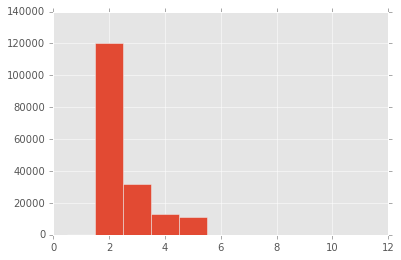

time: 6min 50s


In [6]:
res = all_consecutive_absences(absences)
plt.hist(res, range(1,int(max(res))+3),align='left')

In [9]:
absences.head()

,student_lookup,absence_code,absence_desc,absence_length,date,school,month,week,weekday,grade
0,8210,M,medical,None,2015-04-23,None,4,17,4,8.0
1,8228,M,medical,None,2014-09-23,None,9,39,2,9.0
2,8231,M,medical,None,2014-09-24,None,9,39,3,10.0
3,8552,E,court,0.5,2014-12-09,None,12,50,2,10.0
4,8556,E,court,0.5,2016-03-18,None,3,11,5,12.0


time: 27.6 ms


In [11]:
absent_dates = absences.sort_values(['student_lookup','date'])[['student_lookup', 'absence_desc', 'absence_length', 'date']]
absent_dates.head(10)

,student_lookup,absence_desc,absence_length,date
1393,1,absence_excused,1,2012-10-22
1394,1,absence_excused,1,2012-12-17
1395,1,absence_excused,1,2012-12-18
1396,1,absence_excused,1,2012-12-20
1397,1,absence_excused,1,2012-12-21
1398,1,absence_excused,1,2013-01-04
1399,1,absence_excused,1,2013-01-08
1400,1,absence_excused,1,2013-01-09
1401,1,absence_excused,1,2013-01-10
1402,1,absence_excused,1,2013-01-11


time: 1.31 s


In [12]:
date_pairs = pd.DataFrame()
date_pairs['s1'] = absent_dates[:-1]['student_lookup'].values
date_pairs['s2'] = absent_dates[1:]['student_lookup'].values
date_pairs['d1'] = absent_dates[:-1]['date'].values
date_pairs['d2'] = absent_dates[1:]['date'].values
date_pairs['starting_date'] = None
delta = date_pairs.apply(next_day, axis=1)
date_pairs['delta'] = delta
date_pairs.head()

,s1,s2,d1,d2,starting_date,delta
0,1,1,2012-10-22,2012-12-17,None,0.0
1,1,1,2012-12-17,2012-12-18,None,1.0
2,1,1,2012-12-18,2012-12-20,None,0.0
3,1,1,2012-12-20,2012-12-21,None,1.0
4,1,1,2012-12-21,2013-01-04,None,0.0


time: 3min 19s


In [ ]:
for i in range(1000): #range(date_pairs.shape[0]):
    if i==0 and date_pairs.iloc[i, 5]==1.0:
        date_pairs.iloc[i, 4] = date_pairs.iloc[i, 2]
    elif date_pairs.iloc[i, 5]==1.0 and date_pairs.iloc[i-1, 5]==0.0:
        date_pairs.iloc[i, 4] = date_pairs.iloc[i, 2]
    elif date_pairs.iloc[i, 5]==1.0 and date_pairs.iloc[i-1, 5]==1.0:
        date_pairs.iloc[i, 4] = date_pairs.iloc[i-1, 4]
    else:
        date_pairs.iloc[i, 4] = None

In [17]:
date_pairs.iloc[2, 4]

datetime.date(1, 1, 1)

time: 3.86 ms
